In [1]:
# standard libraries
import sys
import time
import re

# external libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns


# custom libraries
sys.path.append("../")
from YouReader.Reader import Reader



# pandas settings
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', None)
pd.set_option('max_rows', None)

# Constants
TOKEN_PATTERN = r"[^\s]+"

## Loading Data from Save

In [2]:
reader = Reader()
count = reader.load_captions("../data/dataset.json")
df = reader.to_dataframe()
total_sums = df.groupby("subject")["link"].count()

print("Loaded", count, "captions from dataset.json")
print("Data Distribution:", total_sums)

Loaded 2600 captions from dataset.json
Data Distribution: subject
BIOL    200
BUS     200
CHE     200
CHEM    200
CS      200
ECON    200
ENGL    200
HIST    200
MATH    200
PHIL    200
PHYS    200
POSC    200
PSYC    200
Name: link, dtype: int64


<h2>Optional to use and even Dataset (do not run generally)

In [3]:
""""
# erase any unneeded
erase_keys = [key for key in reader.data if reader.data[key]["clean"] == ""]
for key in erase_keys:
    del reader.data[key]
    
# erase keys after the first 200 for each category 
subjects = df["subject"].unique()
dataset = {}
for subject in subjects:
    dataset[subject] = [key for key in reader.data if reader.data[key]["subject"] == subject]
    for key in dataset[subject][200:]:
        del reader.data[key]
"""

'"\n# erase any unneeded\nerase_keys = [key for key in reader.data if reader.data[key]["clean"] == ""]\nfor key in erase_keys:\n    del reader.data[key]\n    \n# erase keys after the first 200 for each category \nsubjects = df["subject"].unique()\ndataset = {}\nfor subject in subjects:\n    dataset[subject] = [key for key in reader.data if reader.data[key]["subject"] == subject]\n    for key in dataset[subject][200:]:\n        del reader.data[key]\n'

## Preparation for Bag of Words Model

In [4]:
# count word frequency of documents based on the subject
def word_frequency_by_subject(subject: str, vectorizer: CountVectorizer) -> pd.DataFrame:
    
    # generates data and labels for subject
    data = df.loc[df["subject"] == subject]["clean"]
    labels = df.loc[df["subject"] == subject]["subject"]
    
    # fits data for vector (generates features)
    data_fitter = vectorizer.fit(data)
    
    # generates vocabulary
    vocab = data_fitter.vocabulary_
    inv_vocab = {v: k for k,v in vocab.items()}
    
    # transform data into a matrix
    data_transform = data_fitter.transform(data)
    data_matrix = data_transform.toarray()
    data_df = pd.DataFrame(data_matrix)
    data_df.rename(columns = inv_vocab, inplace=True)
    
    # get frequency count
    data_sum = data_df.sum(axis=0)
    data_sum.sort_values(inplace=True, ascending=False)
    
    return data_sum

# Overall word frequency
def word_frequency_counter(vectorizer: CountVectorizer) -> pd.DataFrame:
    data = df["clean"]
    
    # fits data for vector (generates features)
    data_fitter = vectorizer.fit(data)
    
    # generates vocabulary
    vocab = data_fitter.vocabulary_
    inv_vocab = {v: k for k,v in vocab.items()}
    
    # transform data into a matrix
    data_transform = data_fitter.transform(data)
    data_matrix = data_transform.toarray()
    data_df = pd.DataFrame(data_matrix)
    data_df.rename(columns = inv_vocab, inplace=True)
    
    # get frequency count
    data_sum = data_df.sum(axis=0)
    data_sum.sort_values(inplace=True, ascending=False)
    
    return data_sum

In [5]:
start_time = time.time()

word_frequency = {}
subjects = df["subject"].unique()
vectorizer = CountVectorizer(stop_words="english", token_pattern=TOKEN_PATTERN)

for subject in subjects:
    word_frequency[subject] = word_frequency_by_subject(subject, vectorizer)
    
print("This takes:", "{:.2f}".format(time.time() - start_time), "seconds")

This takes: 23.76 seconds


<h3>Overall Metrics</h3>

In [6]:
start_time = time.time()

count_vectorizer = CountVectorizer(token_pattern=TOKEN_PATTERN)
new_clean_total = word_frequency_counter(count_vectorizer)

print("This takes:", "{:.2f}".format(time.time() - start_time), "seconds")

This takes: 28.82 seconds


In [7]:
print("Total number of words:", sum(new_clean_total))
print("Total number of unique tokens", len(new_clean_total))

Total number of words: 18829543
Total number of unique tokens 124537


<h1>Exploratory Data Analysis: Overview</h1>
<ol>
    <li>Average Word Length</li>
    <li>Most Diverse Vocabulary</li>
    <li>Most Filler Words</li>
    <li>Most Explicit Words</li>
    <li>First Digit Distribution</li>
    <li>Most Numbers</li>
    <li>Most Dates</li>
</ol>

In [8]:
# https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
def annotate_bargraph(ax, precision =".0f"):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), precision), (p.get_x() + p.get_width() / 2., p.get_height()), ha = "center", va = "center", xytext = (0, 9), textcoords = "offset points")
        
color_palette = ["#335C67", "#ffc971", "#E09F3E", "#842243", "#540B0E", "#472D30", "#9E2A2B", "#aba361", "#436436", "#C9CBA3", "#bc3908", "#b86f52", "#BB8588" ]

<h3>1. Average Word Length</h3>

In [9]:
# returns the average word length for a frequency counter
def get_average_word_length(freq_counts: pd.Series) -> int:
    keys = freq_counts.keys()
    word_count = sum([len(key) for key in keys] * freq_counts) / freq_counts.sum()
    return word_count

In [10]:
word_length_table = {}

for subject in subjects:
    word_length_table[subject] = get_average_word_length(word_frequency[subject])
    
word_length_df = pd.DataFrame.from_dict(word_length_table, orient="index")
word_length_df = word_length_df.sort_values(0, ascending=False)
word_length_df = word_length_df.transpose()
word_length_df

,PHIL,POSC,BUS,HIST,BIOL,PSYC,ENGL,CHEM,ECON,CHE,CS,PHYS,MATH
0,6.47245,6.411806,6.400382,6.359022,6.318926,6.267456,6.151897,5.978319,5.944188,5.744313,5.71272,5.660883,5.274696


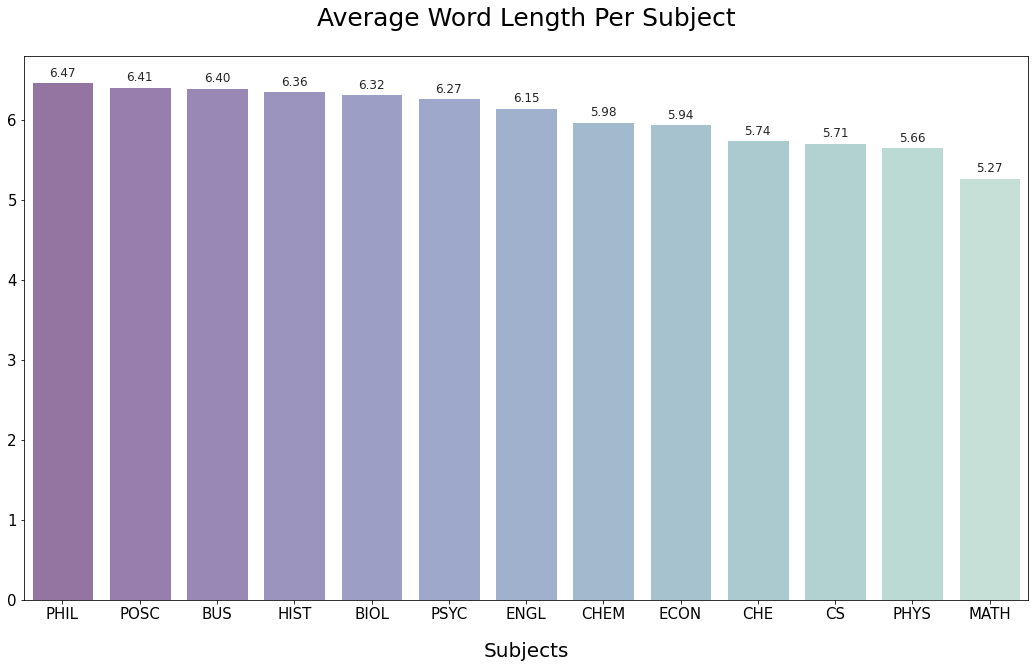

In [11]:
# Figure Preparation
word_length_fig, word_length_axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 10))
sns.set()

# Graph Preparation
word_length_x_vals = word_length_df.columns
word_length_y_vals = word_length_df.loc[0]
word_length_graph = sns.barplot(x = word_length_x_vals, y = word_length_y_vals, palette="ch:s=-1.2,r=-1,d=.5_r")
word_length_graph.set_title("Average Word Length Per Subject", size = 25, pad = 30)
word_length_graph.set_xlabel("Subjects", size = 20, labelpad = 20)
word_length_graph.set_ylabel("", size = 20, labelpad = 0)
word_length_graph.tick_params(axis = "x", labelsize = 15, rotation = 0)
word_length_graph.tick_params(axis = "y", labelsize = 15)
annotate_bargraph(word_length_graph, ".2f")

<h3>2. Most Diverse Vocabulary</h3>

In [12]:
# returns length of frequency series
def get_diversity_count(freq_counts: pd.Series) -> int:
    return len(freq_counts)

In [13]:
diversity_count_table = {}

for subject in subjects:
    diversity_count_table[subject] = get_diversity_count(word_frequency[subject])

diversity_count_df = pd.DataFrame.from_dict(diversity_count_table, orient='index')
diversity_count_df = diversity_count_df.sort_values(0, ascending=False)
diversity_count_df = diversity_count_df.transpose()
diversity_count_df

,HIST,ENGL,POSC,BUS,PHIL,PSYC,BIOL,ECON,CS,CHEM,PHYS,MATH,CHE
0,42916,39740,32773,27001,26885,26488,24559,22478,21020,20232,18658,18282,16515


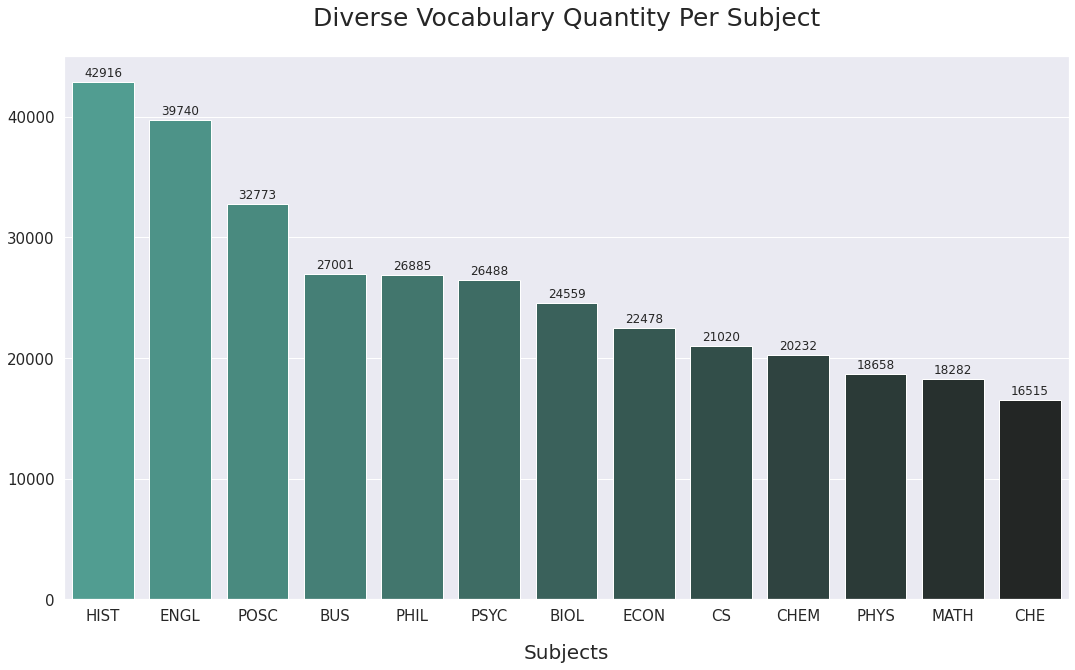

In [14]:
# Figure Preparation
diversity_count_fig, diversity_count_axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 10))
sns.set()

# Graph Preparation
diversity_count_x_vals = diversity_count_df.columns
diversity_count_y_vals = diversity_count_df.loc[0]
diversity_count_graph = sns.barplot(x = diversity_count_x_vals, y = diversity_count_y_vals, palette="dark:#4A9_r")
diversity_count_graph.set_title("Diverse Vocabulary Quantity Per Subject", size = 25, pad = 30)
diversity_count_graph.set_xlabel("Subjects", size = 20, labelpad = 20)
diversity_count_graph.set_ylabel("", size = 20, labelpad = 0)
diversity_count_graph.tick_params(axis = "x", labelsize = 15, rotation = 0)
diversity_count_graph.tick_params(axis = "y", labelsize = 15)
annotate_bargraph(diversity_count_graph)

<h3>3. Most Filler Words</h3>

In [15]:
with open("../data/analysis/filler.txt") as inFile:
    filler_words = inFile.read().split("\n")

# returns frequencies of filler words from facebook filter list
def get_filler_freq(freq_counts: pd.Series) -> dict:
    freq_counts_dict = freq_counts.to_dict()
    filler_measure = {k:v for k,v in freq_counts_dict.items() if k in filler_words}
    return filler_measure

In [16]:
filler_freq_table = {}
filler_sum_table = {}

for subject in subjects:
    filler_freq_table[subject] = get_filler_freq(word_frequency[subject])
    filler_sum_table[subject] = sum(filler_freq_table[subject].values())
    
filler_count_df = pd.DataFrame.from_dict(filler_sum_table, orient='index')
filler_count_df = filler_count_df.sort_values(0, ascending=False)
filler_count_df = filler_count_df.transpose()
filler_count_df

,CS,POSC,MATH,ECON,CHEM,CHE,BIOL,PHYS,ENGL,PSYC,BUS,PHIL,HIST
0,18196,9887,9111,8194,7930,5422,5194,4813,3626,3625,3614,2425,1971


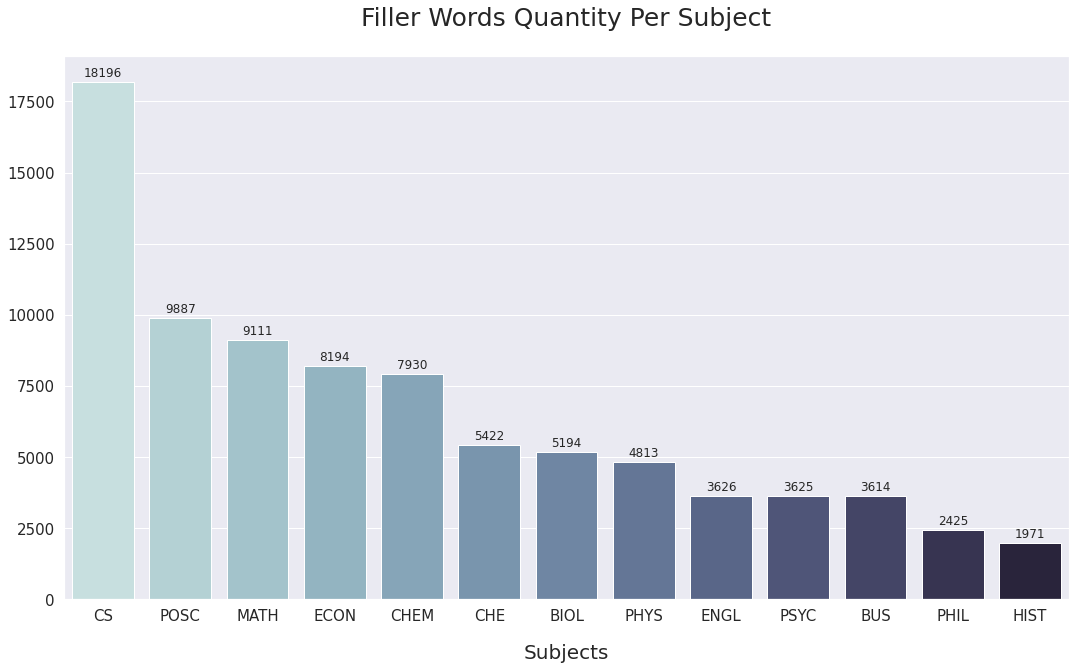

In [17]:
filler_count_fig, filler_count_axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 10))
sns.set()

# Graph Preparation
filler_count_x_vals = filler_count_df.columns
filler_count_y_vals = filler_count_df.loc[0]
filler_count_graph = sns.barplot(x = filler_count_x_vals, y = filler_count_y_vals, palette="ch:s=.2,r=-.3")
filler_count_graph.set_title("Filler Words Quantity Per Subject", size = 25, pad = 30)
filler_count_graph.set_xlabel("Subjects", size = 20, labelpad = 20)
filler_count_graph.set_ylabel("", size = 20, labelpad = 60, rotation=0)
filler_count_graph.tick_params(axis = "x", labelsize = 15, rotation = 0)
filler_count_graph.tick_params(axis = "y", labelsize = 15)
annotate_bargraph(filler_count_graph)

<h3>4. Most Explicit Words</h3>

In [18]:
with open("../data/analysis/swear.txt") as inFile:
    swear_words = inFile.read().split("\n")
    
# returns frequencies of swear words from facebook filter list
def get_swear_freq(freq_counts: pd.Series) -> dict:
    freq_counts_dict = freq_counts.to_dict()
    swear_measure = {k:v for k,v in freq_counts_dict.items() if k in swear_words}
    return swear_measure

In [19]:
swear_freq_table = {}
swear_sum_table = {}

for subject in subjects:
    swear_freq_table[subject] = get_swear_freq(word_frequency[subject])
    swear_sum_table[subject] = sum(swear_freq_table[subject].values())

swear_count_df = pd.DataFrame.from_dict(swear_sum_table, orient='index')
swear_count_df = swear_count_df.sort_values(0, ascending=False)
swear_count_df = swear_count_df.transpose()

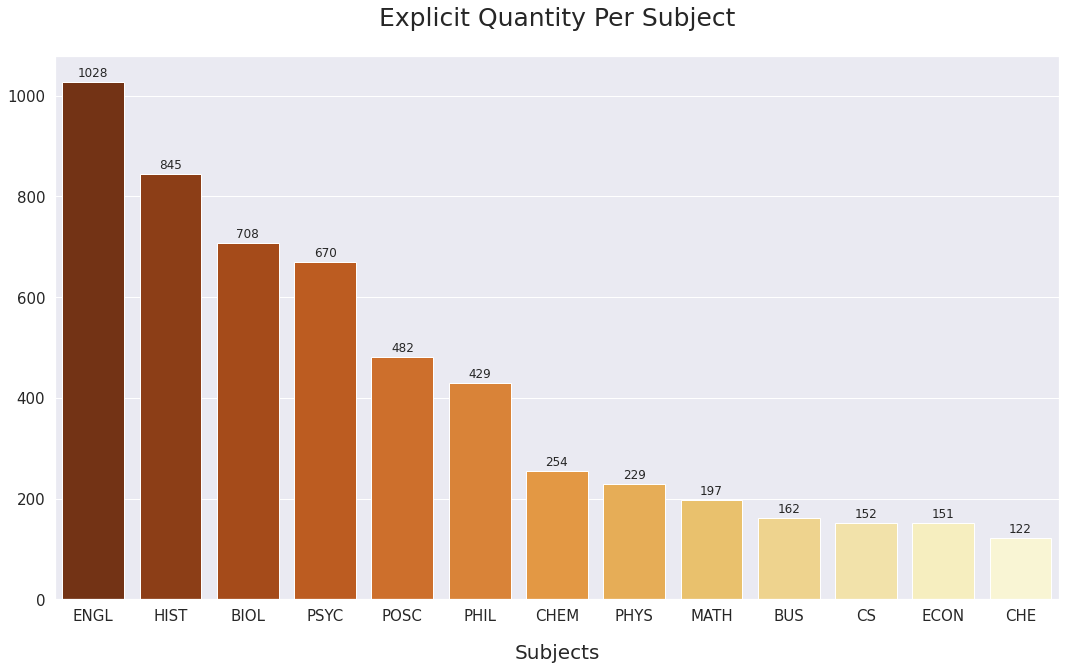

In [20]:
# Figure preparation
fig,axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18,10))
sns.set()

# Graph preparation
x_vals = swear_count_df.columns
y_vals = swear_count_df.loc[0]
swear_count_graph = sns.barplot(x=x_vals, y=y_vals, palette="YlOrBr_r")
swear_count_graph.set_title("Explicit Quantity Per Subject", size=25, pad=30)
swear_count_graph.set_xlabel("Subjects", size=20, labelpad=20)
swear_count_graph.set_ylabel("", size=20, labelpad=60, rotation=0)
swear_count_graph.tick_params(axis='x', labelsize=15, rotation=0)
swear_count_graph.tick_params(axis='y', labelsize=15)
annotate_bargraph(swear_count_graph)

<h3>5. First Digit Distribution</h3>

In [21]:
digit_regexes = [r"\b0.+", r"\b1.+", r"\b2.+", r"\b3.+", r"\b4.+", r"\b5.+", r"\b6.+", r"\b7.+", r"\b8.+", r"\b9.+"]
first_digit_columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, "total", "subject"]

# total counts for starting digits 0-9
def get_first_digits_freq(freq_counts: pd.Series, subject: str) -> dict:
    digit_freq = []
    digit_sums = {}
    keys = freq_counts.keys()
    
    for i in range(len(digit_regexes)):
        digit_freq = [freq_counts[key] for key in keys if re.match(digit_regexes[i], key)]
        digit_sums[i] = sum(digit_freq)
    
    digit_sums["total"] = sum(digit_sums.values())
    digit_sums["subject"] = subject
    return digit_sums

In [22]:
first_digits_freq_table = {}
first_digits_df = pd.DataFrame(columns=first_digit_columns)

# first digits
for subject in subjects:
    
    first_digits_freq_table[subject] = get_first_digits_freq(word_frequency[subject], subject)  
    first_digits_df = first_digits_df.append(first_digits_freq_table[subject], ignore_index=True)

first_digits_df.set_index("subject", inplace=True)
first_digits_df_sum = pd.DataFrame(first_digits_df.sum(axis=0))
first_digits_df_sum = first_digits_df_sum.transpose()
first_digits_df_sum.drop(columns=["total"], inplace=True)

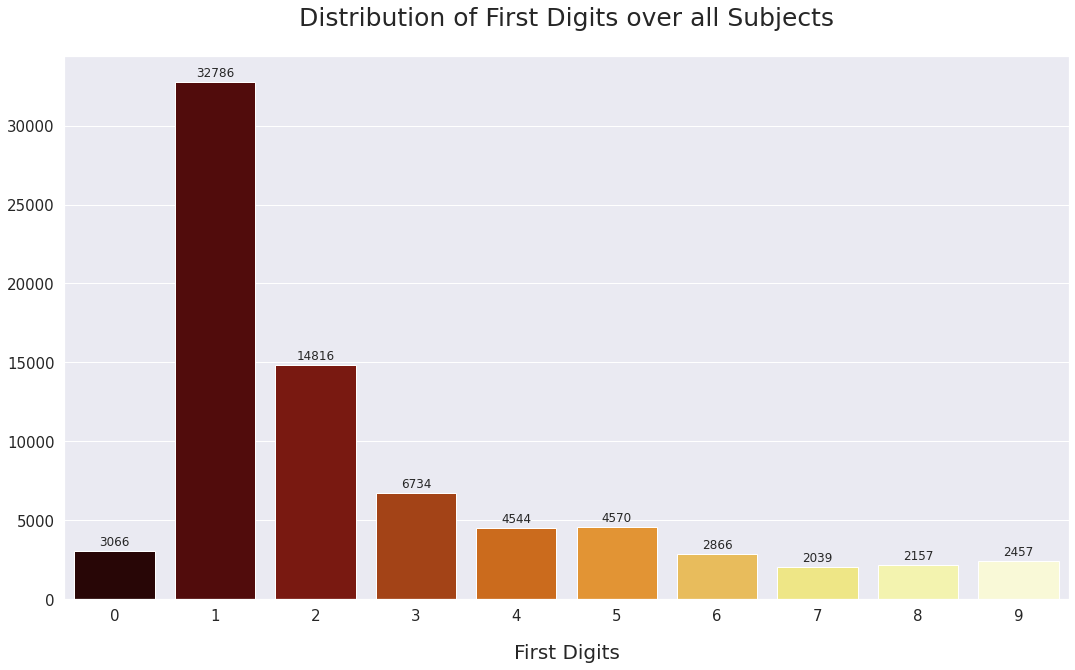

In [23]:
# Figure Preparation
fig,axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18,10))
sns.set()

# Graph Preparation
y_vals = first_digits_df_sum.loc[0]
x_vals = first_digits_df_sum.columns
first_digits_df_sum_graph = sns.barplot(x=x_vals, y=y_vals, palette="afmhot")
first_digits_df_sum_graph.set_title("Distribution of First Digits over all Subjects", size=25, pad=30)
first_digits_df_sum_graph.set_xlabel("First Digits", size=20, labelpad=20)
first_digits_df_sum_graph.set_ylabel("", size=20, labelpad=60, rotation=0)
first_digits_df_sum_graph.tick_params(axis='x', labelsize=15, rotation=0)
first_digits_df_sum_graph.tick_params(axis='y', labelsize=15)
annotate_bargraph(first_digits_df_sum_graph)

<h3>6. Most Numbers</h3>

In [24]:
numbers_df = first_digits_df[["total"]]
numbers_df = numbers_df.sort_values("total", ascending=False)
numbers_df = numbers_df.transpose()
numbers_df

subject,MATH,ECON,CHE,HIST,BUS,CS,POSC,PHYS,CHEM,BIOL,PSYC,ENGL,PHIL
total,9066,8993,8707,7852,5915,5908,5803,5419,5313,3969,3509,3268,2313


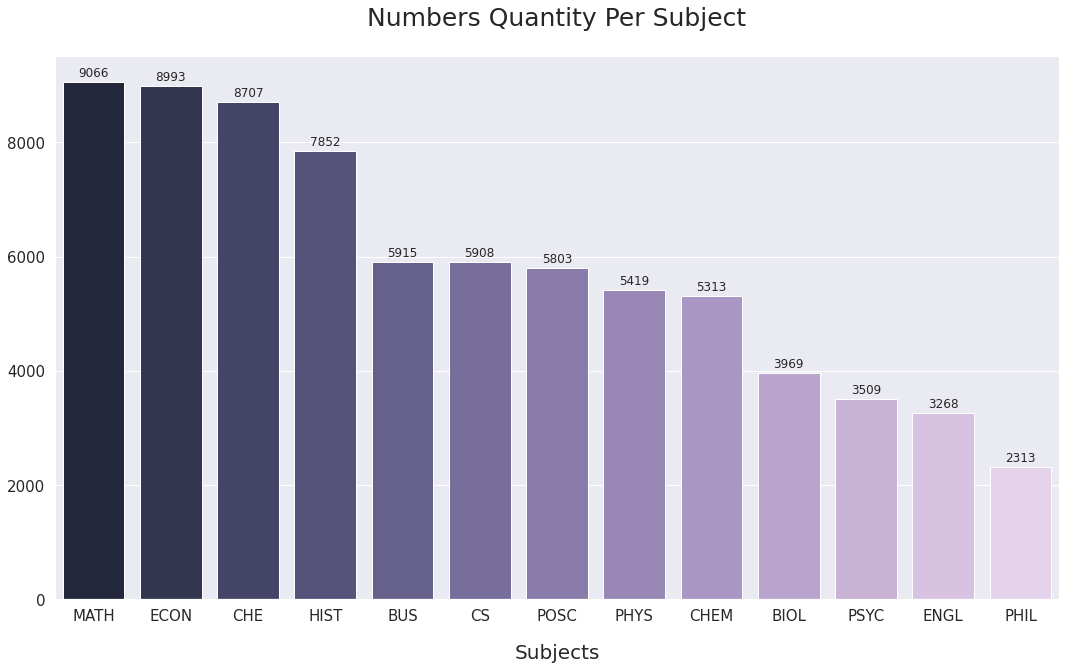

In [25]:
fig,axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18,10))
sns.set()

y_vals = numbers_df.loc['total']
x_vals = numbers_df.columns
numbers_count_graph = sns.barplot(x = x_vals, y = y_vals, palette ="ch:s=-.2,r=.2_r")
numbers_count_graph.set_title("Numbers Quantity Per Subject", size=25, pad=30)
numbers_count_graph.set_xlabel("Subjects", size=20, labelpad=20)
numbers_count_graph.set_ylabel("", size=20, labelpad=40, rotation=0)
numbers_count_graph.tick_params(axis='x', labelsize=15, rotation=0)
numbers_count_graph.tick_params(axis='y', labelsize=15)
annotate_bargraph(numbers_count_graph)

<h3>7. Most Dates</h3>

In [26]:
date_pattern = r"\b[0-9]{3,4}s\b|\b[0-9]{4}\b"

def get_date_freq(freq_counts: pd.Series) -> dict:
    freq_counts_dict = freq_counts.to_dict()
    date_measure = {k:v for k,v in freq_counts_dict.items() if re.match(date_pattern, k)}
    return date_measure


In [27]:
date_freq_table = {}
date_sum_table = {}

# most dates
for subject in subjects:
    date_freq_table[subject] = get_date_freq(word_frequency[subject])
    date_sum_table[subject] = sum(date_freq_table[subject].values())
    
date_count_df = pd.DataFrame.from_dict(date_sum_table, orient='index')
date_count_df = date_count_df.sort_values(0, ascending=False)
date_count_df = date_count_df.transpose()

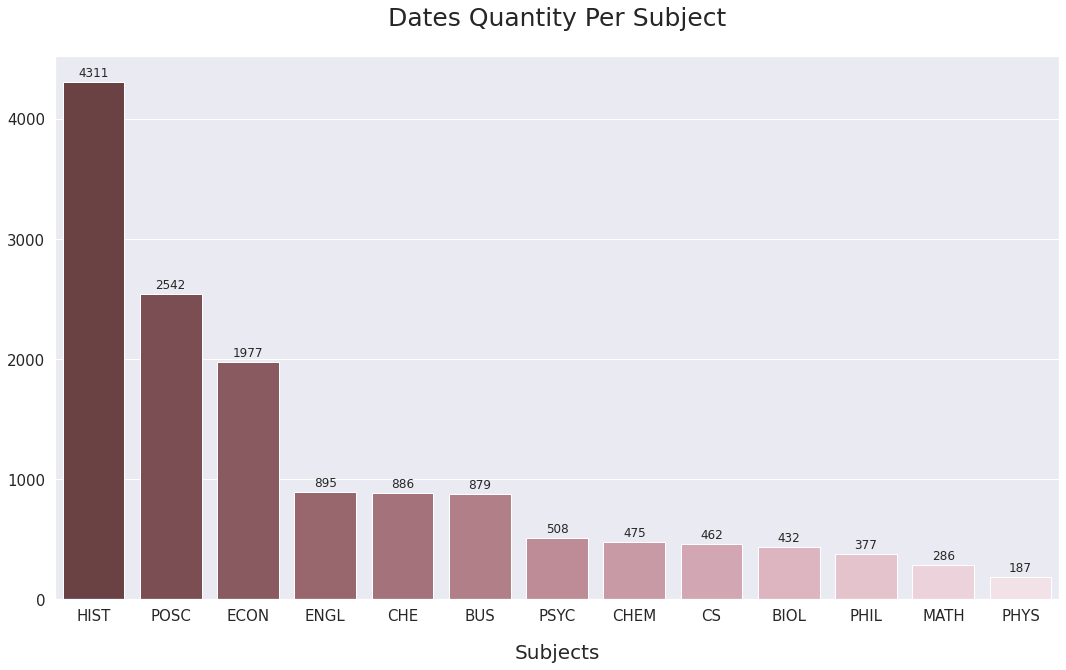

In [28]:
# Figure preparation
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
sns.set()

# Graph preparation
x_vals = date_count_df.columns
y_vals = date_count_df.loc[0]
ax = sns.barplot(x=x_vals, y=y_vals, palette="ch:s=1.0,r=-.1,d=.3,l=.9_r")
ax.set_title("Dates Quantity Per Subject", size=25, pad=30)
ax.set_xlabel("Subjects", size=20, labelpad=20)
ax.set_ylabel("", size=20, labelpad=40, rotation=0)
ax.tick_params(axis='x', labelsize=15, rotation=0)
ax.tick_params(axis='y', labelsize=15)
annotate_bargraph(ax)